In [6]:
import psycopg2
from dotenv import load_dotenv
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [7]:
CURR_DIR=os.getcwd()
print(CURR_DIR)
env_file_path=os.path.join(os.path.dirname(CURR_DIR), 'var.env')
print(env_file_path)

# load the environment variables
load_dotenv(env_file_path)
env=os.environ

DBNAME=env.get('DBNAME')
USERNAME=env.get('USERNAME')
PASSWORD=env.get('PASSWORD')
HOSTNAME=env.get('HOSTNAME')
PORT=env.get('PORT')
SCHEMA=env.get('SCHEMA')
print(f"Schema : {SCHEMA}")
print(f"DBName: {DBNAME} HOSTNAME: {HOSTNAME}")

/Users/kevinli/Downloads/MLDS_400_G11-team_experiments/DataCleaning
/Users/kevinli/Downloads/MLDS_400_G11-team_experiments/var.env
Schema : group_11
DBName: everything2023 HOSTNAME: pg.analytics.northwestern.edu


In [8]:
# Establish the connection
conn = psycopg2.connect(
    dbname=DBNAME,
    user=USERNAME,
    password=PASSWORD,
    host=HOSTNAME,
    port=PORT
)

# Create a cursor object to interact with the database
cur = conn.cursor()

# Setting the SearchPath to Group Schema
cur.execute(f"SET search_path TO {SCHEMA};")

In [9]:
# Getting Data from DeptInfo
cur.execute("SELECT * FROM deptinfo;")
column_names = [desc[0] for desc in cur.description]
print(column_names)

rows = cur.fetchall()
df_deptinfo = pd.DataFrame(rows, columns=column_names)
df_deptinfo.head()

['DEPT', 'DEPTDESC']


,DEPT,DEPTDESC
0,800,CLINIQUE
1,801,LESLIE
2,1100,GARY F
3,1107,JACQUES
4,1202,CABERN


In [10]:
# Getting Data from Skstinfo
cur.execute("SELECT * FROM skstinfo;")
column_names = [desc[0] for desc in cur.description]
print(column_names)

rows = cur.fetchall()
df_skstinfo = pd.DataFrame(rows, columns=column_names)
df_skstinfo.head()

['SKU', 'STORE', 'COST', 'RETAIL']


,SKU,STORE,COST,RETAIL
0,3,102,123.36,440.0
1,3,103,123.36,440.0
2,3,104,123.36,440.0
3,3,202,123.36,440.0
4,3,203,123.36,440.0


In [11]:
df_skstinfo_orig = df_skstinfo.copy()

In [12]:
# Getting Data from skutinfo
cur.execute("SELECT * FROM skuinfo;")
column_names = [desc[0] for desc in cur.description]
print(column_names)

rows = cur.fetchall()
df_skuinfo = pd.DataFrame(rows, columns=column_names)


df_skuinfo_orig = df_skuinfo.copy()
df_skuinfo.head()

['SKU', 'DEPT', 'CLASSID', 'UPC', 'STYLE', 'COLOR', 'SIZE', 'PACKSIZE', 'VENDOR', 'BRAND']


,SKU,DEPT,CLASSID,UPC,STYLE,COLOR,SIZE,PACKSIZE,VENDOR,BRAND
0,3,6505,113,400000003000,00 F55KT2,WHISPERWHITE,P8EA,1,5119207,TURNBURY
1,4,8101,002,400000004000,22 615CZ4,SPEARMI,S,1,3311144,C A SPOR
2,5,7307,003,400000005000,7LBS 245-01,34 SILVER,KING,1,5510554,BEAU IDE
3,8,3404,00B,400000008000,622 F05H84,MORNING MI,2T,1,2912827,HARTSTRI
4,15,2301,004,400000015000,126 MDU461,255CAMEL,12,1,23272,JONES/LA


In [13]:
# Getting Data from strinfo
cur.execute("SELECT * FROM strinfo;")
column_names = [desc[0] for desc in cur.description]
print(column_names)

rows = cur.fetchall()
df_strinfo = pd.DataFrame(rows, columns=column_names)
df_strinfo.head()

['STORE', 'CITY', 'STATE', 'ZIP']


,STORE,CITY,STATE,ZIP
0,2,ST. PETERSBURG,FL,33710
1,3,ST. LOUIS,MO,63126
2,4,LITTLE ROCK,AR,72201
3,7,FORT WORTH,TX,76137
4,9,TEMPE,AZ,85281


In [14]:
df_strinfo_orig = df_strinfo.copy()

In [15]:
# Getting Data from trnsact
cur.execute("SELECT * FROM trnsact ORDER BY RANDOM() LIMIT 1000000;")
column_names = [desc[0] for desc in cur.description]
print(column_names)

rows = cur.fetchall()
df_trnsact = pd.DataFrame(rows, columns=column_names)
df_trnsact.head()

['SKU', 'STORE', 'REGISTER', 'TRANNUM', 'SEQ', 'SALEDATE', 'STYPE', 'QUANTITY', 'ORGPRICE', 'SPRICE', 'AMT', 'INTERID', 'MIC']


,SKU,STORE,REGISTER,TRANNUM,SEQ,SALEDATE,STYPE,QUANTITY,ORGPRICE,SPRICE,AMT,INTERID,MIC
0,9590684,2203,730,2100,0,2005-05-07,P,1,7.0,7.00,7.00,915300013,896
1,704286,4504,150,1700,719108580,2004-11-24,P,1,94.0,47.24,47.24,287700035,680
2,1084283,2004,350,4400,319005873,2004-12-24,P,1,56.0,28.00,28.00,805600068,680
3,3512831,6004,660,3600,0,2005-03-19,P,1,22.0,22.00,22.00,895800020,643
4,6949904,8402,920,200,0,2005-06-19,P,1,4.0,4.00,4.00,85300052,146


In [16]:
df_trnsact_orig = df_trnsact.copy()

In [17]:
def find_empty_spaces(df, col_name):
    print(f"Analysing {col_name}")
    for _ in df[col_name].unique():
        if not(len(_) == len(_.strip()) and len(_) > 0):
            print(f"Found Empty Spaces! Fix {col_name}")
            break
            
def _fix_empty_spaces(entry):
    if len(entry) == 0:
        return None
    
    return entry.strip()

def fix_empty_spaces(df, col_name):
    df[col_name] = df[col_name].apply(lambda x : _fix_empty_spaces(x))
    df.dropna(subset=[col_name], inplace=True)
    return df

# Department Table

Columns Description
- DEPT: Department where the stock item belong
- DEPTDESC: Description of the department

In [18]:
df_deptinfo.head(5)

,DEPT,DEPTDESC
0,800,CLINIQUE
1,801,LESLIE
2,1100,GARY F
3,1107,JACQUES
4,1202,CABERN


In [19]:
for column in df_deptinfo.columns:
    print(column, df_deptinfo[column].dtype)

DEPT int64
DEPTDESC object


In [20]:
df_deptinfo.DEPTDESC.unique().shape[0], df_deptinfo.DEPT.unique().shape[0]

(60, 60)

In [21]:
unique_departments = df_deptinfo.DEPT.unique()
print(f"Total Unique Departments : {len(unique_departments)}")

Total Unique Departments : 60


In [22]:
find_empty_spaces(df=df_deptinfo, col_name='DEPTDESC')

Analysing DEPTDESC


# Skuinfo Table

**Columns Description**:
- SKU: Stock Keeping Unit number of the stock item
- DEPT: Department where the stock item belong
- CLASSID: Stock Item Classification
- UPC: Universal Product Code for the stock item 
- STYLE: The specific style of the stock item 
- COLOR: The color of the stock item
- SIZE: The size of the stock item
- PACKSIZE: The quantity of item per pack
- VENDOR: The vendor number of the stock item
- BRAND: The brand name of the stock item

**Insights**
- The SKU Table contains unique Stock IDs (SKU). No Repetition is there 
- Total Unique Stocks : 1556039

In [23]:
for column in df_skuinfo.columns:
    print(column, df_skuinfo[column].dtype)

SKU int64
DEPT int64
CLASSID object
UPC int64
STYLE object
COLOR object
SIZE object
PACKSIZE int64
VENDOR int64
BRAND object


In [24]:
df_skuinfo.head()

,SKU,DEPT,CLASSID,UPC,STYLE,COLOR,SIZE,PACKSIZE,VENDOR,BRAND
0,3,6505,113,400000003000,00 F55KT2,WHISPERWHITE,P8EA,1,5119207,TURNBURY
1,4,8101,002,400000004000,22 615CZ4,SPEARMI,S,1,3311144,C A SPOR
2,5,7307,003,400000005000,7LBS 245-01,34 SILVER,KING,1,5510554,BEAU IDE
3,8,3404,00B,400000008000,622 F05H84,MORNING MI,2T,1,2912827,HARTSTRI
4,15,2301,004,400000015000,126 MDU461,255CAMEL,12,1,23272,JONES/LA


In [25]:
df_skuinfo.UPC.unique().shape, df_skuinfo.SKU.unique().shape

((1556039,), (1556039,))

In [26]:
#df_skuinfo = df_skuinfo_orig.copy()

In [27]:
find_empty_spaces(df_skuinfo, col_name="STYLE")
find_empty_spaces(df_skuinfo, col_name="COLOR")
find_empty_spaces(df_skuinfo, col_name="SIZE")
find_empty_spaces(df_skuinfo, col_name="BRAND")

Analysing STYLE
Analysing COLOR
Found Empty Spaces! Fix COLOR
Analysing SIZE
Analysing BRAND
Found Empty Spaces! Fix BRAND


In [28]:
df_skuinfo = fix_empty_spaces(df_skuinfo, col_name="COLOR")
find_empty_spaces(df_skuinfo, col_name="COLOR")

Analysing COLOR


In [29]:
df_skuinfo = fix_empty_spaces(df_skuinfo, col_name="BRAND")
find_empty_spaces(df_skuinfo, col_name="BRAND")

Analysing BRAND


In [30]:
# Checking for null values
df_skuinfo.isnull().sum()

SKU         0
DEPT        0
CLASSID     0
UPC         0
STYLE       0
COLOR       0
SIZE        0
PACKSIZE    0
VENDOR      0
BRAND       0
dtype: int64

In [31]:
# Unique Values of all the Columns
print(f"DataSize: {df_skuinfo.shape[0]}")
df_skuinfo.nunique()

DataSize: 1531682


SKU         1531682
DEPT             60
CLASSID        1054
UPC         1531682
STYLE        310592
COLOR         70884
SIZE           9777
PACKSIZE         48
VENDOR         2351
BRAND          1930
dtype: int64

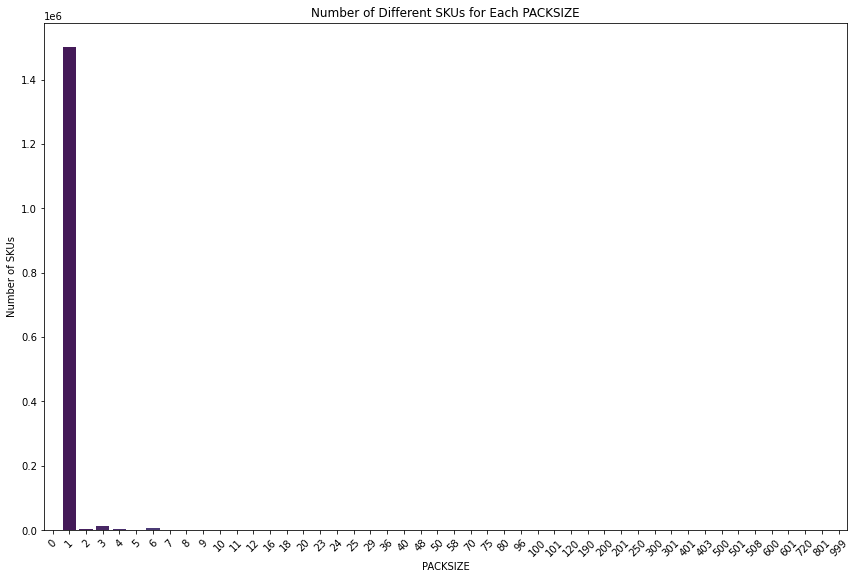

In [32]:
packsize_sku_counts = df_skuinfo.groupby('PACKSIZE')['SKU'].nunique().reset_index()
plt.figure(figsize=(12, 8))
sns.barplot(x='PACKSIZE', y='SKU', data=packsize_sku_counts, palette='viridis')
plt.title('Number of Different SKUs for Each PACKSIZE')
plt.xlabel('PACKSIZE')
plt.ylabel('Number of SKUs')
plt.tight_layout()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

# STRINFO 
Store Information

Column Descriptions:
- STORE: Store Number
- CITY : City Name
- STATE : State Name
- ZIP : Zip Code

In [33]:
df_strinfo.isnull().sum()

STORE    0
CITY     0
STATE    0
ZIP      0
dtype: int64

In [34]:
for column in df_strinfo.columns:
    print(column, df_strinfo[column].dtype)

STORE int64
CITY object
STATE object
ZIP int64


In [35]:
print(f"Distinct Value Counts for Column Names")
for col_name, val in df_strinfo.nunique().to_dict().items():
    print(f"{col_name} : {val}")

Distinct Value Counts for Column Names
STORE : 453
CITY : 299
STATE : 31
ZIP : 391


In [36]:
find_empty_spaces(df_strinfo, 'CITY')
find_empty_spaces(df_strinfo, 'STATE')

fix_empty_spaces(df_strinfo, 'CITY')
fix_empty_spaces(df_strinfo, 'STATE')

find_empty_spaces(df_strinfo, 'CITY')
find_empty_spaces(df_strinfo, 'STATE')

Analysing CITY
Analysing STATE
Analysing CITY
Analysing STATE


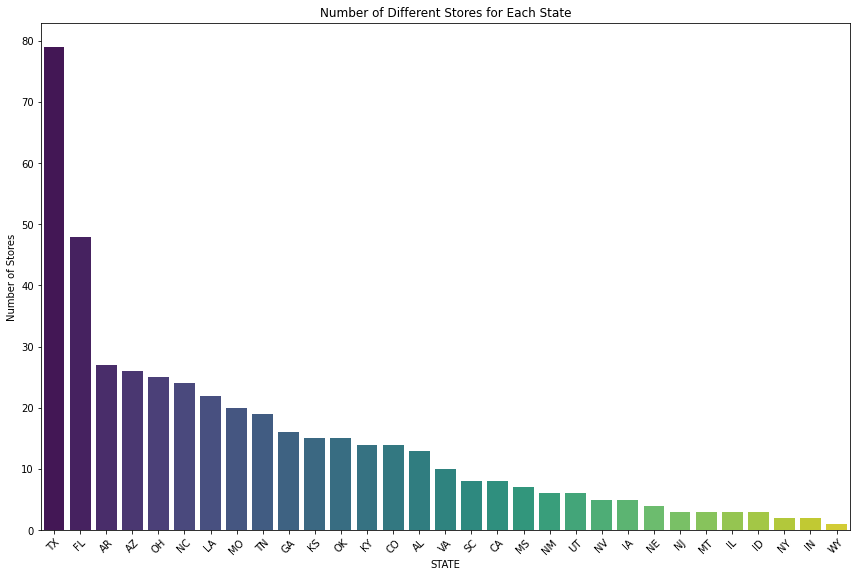

In [37]:
state_store_counts = df_strinfo.groupby('STATE')['STORE'].nunique().sort_values(ascending=False).reset_index()
plt.figure(figsize=(12, 8))
sns.barplot(x='STATE', y='STORE', data=state_store_counts, palette='viridis')
plt.title('Number of Different Stores for Each State')
plt.xlabel('STATE')
plt.ylabel('Number of Stores')
plt.tight_layout()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

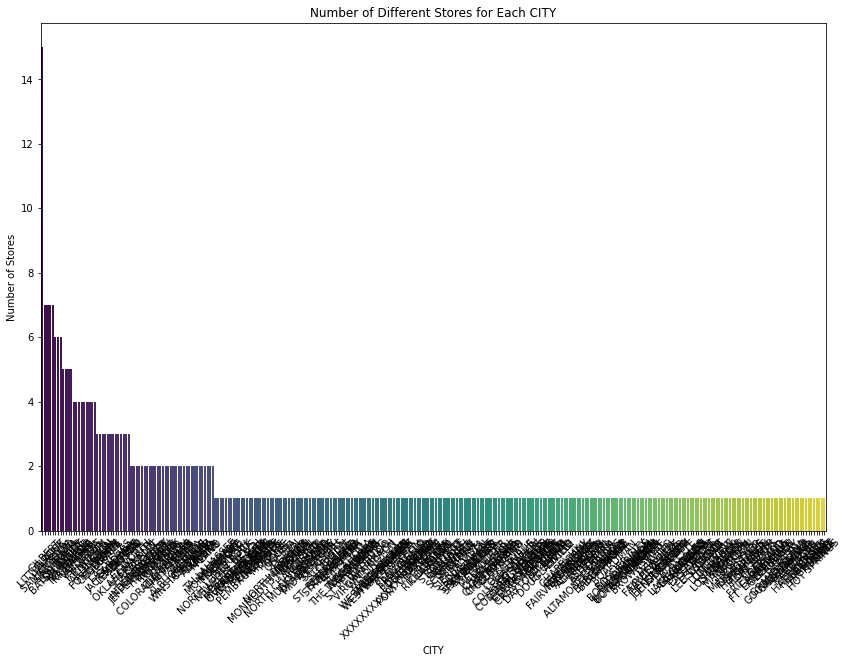

In [38]:
city_store_counts = df_strinfo.groupby('CITY')['STORE'].nunique().sort_values(ascending=False).reset_index()
plt.figure(figsize=(12, 8))
sns.barplot(x='CITY', y='STORE', data=city_store_counts, palette='viridis')
plt.title('Number of Different Stores for Each CITY')
plt.xlabel('CITY')
plt.ylabel('Number of Stores')
plt.tight_layout()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

# SKSTINFO

Columns Description
- SKU : Stock Keeping Unit number of the stock item
- STORE : Store Number
- COST : Cost Price of the Stock
- RETAIL : Selling Price of the Stock

Some Insights:
- 395409 Stocks are actually sold at Stores with cost and retail price
- SKUs with Zero Cost and Retail : 1445
- SKUs with Zero Cost : 1495
- SKUs with Zero Retail : 1474


In [39]:
for col in df_skstinfo.columns:
    print(col, df_skstinfo[col].dtype)

SKU int64
STORE int64
COST float64
RETAIL float64


In [40]:
df_skstinfo.head()

,SKU,STORE,COST,RETAIL
0,3,102,123.36,440.0
1,3,103,123.36,440.0
2,3,104,123.36,440.0
3,3,202,123.36,440.0
4,3,203,123.36,440.0


In [41]:
df_skstinfo.isnull().sum()

SKU       0
STORE     0
COST      0
RETAIL    0
dtype: int64

In [42]:
df_skstinfo.SKU.unique().shape

(395409,)

In [43]:
sku_avg_cost = df_skstinfo.groupby('SKU')['COST'].mean().sort_values(ascending=False).reset_index()
sku_avg_cost.head(10)

,SKU,COST
0,1811281,1872.54
1,3678048,1854.96
2,4338048,1747.20
3,860149,1710.96
4,5168032,1651.20
5,159502,1638.24
6,920147,1464.00
7,1220149,1462.56
8,1099502,1420.56
9,969502,1420.56


In [44]:
sku_avg_cost.tail(10)

,SKU,COST
395399,1879389,0.0
395400,1127318,0.0
395401,3772914,0.0
395402,1471287,0.0
395403,3773115,0.0
395404,3774475,0.0
395405,4801484,0.0
395406,264195,0.0
395407,2523842,0.0
395408,2031335,0.0


In [45]:
sku_avg_retail = df_skstinfo.groupby('SKU')['RETAIL'].mean().sort_values(ascending=False).reset_index()
sku_avg_retail.head(10)

,SKU,RETAIL
0,1811281,5850.0
1,1220149,5280.0
2,969502,4320.0
3,159502,4320.0
4,569502,4320.0
5,1099502,4320.0
6,699502,4320.0
7,439502,4320.0
8,920147,4080.0
9,860149,4080.0


In [46]:
skus_avg_prices = sku_avg_cost.merge(sku_avg_retail, on='SKU', how='inner')
skus_avg_prices.head()

,SKU,COST,RETAIL
0,1811281,1872.54,5850.0
1,3678048,1854.96,2160.0
2,4338048,1747.20,2160.0
3,860149,1710.96,4080.0
4,5168032,1651.20,2280.0


In [47]:
skus_with_zero_cost_retail = skus_avg_prices[(skus_avg_prices.COST==0.0) & (skus_avg_prices.RETAIL==0.0)]
print(f"SKUs with Zero Cost and Retail : {skus_with_zero_cost_retail.shape[0]}")

skus_with_zero_cost = skus_avg_prices[(skus_avg_prices.COST==0.0)]
skus_with_zero_retail = skus_avg_prices[(skus_avg_prices.RETAIL==0.0)]
print(f"SKUs with Zero Cost : {skus_with_zero_cost.shape[0]}")
print(f"SKUs with Zero Retail : {skus_with_zero_retail.shape[0]}")

SKUs with Zero Cost and Retail : 1445
SKUs with Zero Cost : 1495
SKUs with Zero Retail : 1474


In [48]:
df_skstinfo.groupby('STORE')['SKU'].nunique().sort_values(ascending=False).reset_index()

,STORE,SKU
0,2203,113188
1,8402,109454
2,209,101766
3,9103,101533
4,1709,99356
...,...,...
350,7700,23
351,7300,22
352,300,7
353,400,7


In [49]:
df_skstinfo[df_skstinfo.STORE==2203].shape

(113188, 4)

# Trnsact

**Columns Description**
- SKU:      Stock Keeping Unit number of the stock item
- STORE:    Store Number
- REGISTER: Register Number of the current transaction 
- TRANNUM:  Transaction Code
- SEQ:      Sequence number
- SALEDATE: Sale date of the item stock 
- STYPE:    Type of the transaction (Return or Purchase) ( P/R)
- QUANTITY: Item quantity of the transaction
- ORGPRICE: Original price of the item stock
- SPRICE:   Sale price of the item stock
- AMT:      Total amount of the transaction charge to the customer 26
- INTERID:  Internal ID
- MIC:      Master Item Code


Stores have SKUs now, which are not mentioned in skst table, meaning now Stores have upgraded stocks

In [50]:
for col in df_trnsact.columns:
    print(col, df_trnsact[col].dtype)

SKU int64
STORE int64
REGISTER int64
TRANNUM int64
SEQ int64
SALEDATE object
STYPE object
QUANTITY int64
ORGPRICE float64
SPRICE float64
AMT float64
INTERID int64
MIC int64


In [51]:
print(df_trnsact.STYPE.unique())

['P' 'R']


In [52]:
df_trnsact.isnull().sum()

SKU         0
STORE       0
REGISTER    0
TRANNUM     0
SEQ         0
SALEDATE    0
STYPE       0
QUANTITY    0
ORGPRICE    0
SPRICE      0
AMT         0
INTERID     0
MIC         0
dtype: int64

In [53]:
"""
1) Directly predict the selling price
2) Consider Past info as well and predict the SPrice
"""
df_trnsact.head()

,SKU,STORE,REGISTER,TRANNUM,SEQ,SALEDATE,STYPE,QUANTITY,ORGPRICE,SPRICE,AMT,INTERID,MIC
0,9590684,2203,730,2100,0,2005-05-07,P,1,7.0,7.00,7.00,915300013,896
1,704286,4504,150,1700,719108580,2004-11-24,P,1,94.0,47.24,47.24,287700035,680
2,1084283,2004,350,4400,319005873,2004-12-24,P,1,56.0,28.00,28.00,805600068,680
3,3512831,6004,660,3600,0,2005-03-19,P,1,22.0,22.00,22.00,895800020,643
4,6949904,8402,920,200,0,2005-06-19,P,1,4.0,4.00,4.00,85300052,146


In [54]:
# Creating Copies of the DataFrames to be used for experimentation
# df_skuinfo -> df_sku , df_strinfo -> df_str , df_skstinfo -> df_skst, df_trnsact -> df_trans

df_sku = df_skuinfo.copy()
df_str = df_strinfo.copy()
df_skst = df_skstinfo.copy()
df_trans = df_trnsact.copy()

print(df_sku.shape[0], df_str.shape[0], df_skst.shape[0], df_trans.shape[0])

1531682 453 20640000 1000000


In [55]:
# Dropping not to be used columns
df_sku = df_sku[['SKU','DEPT', 'PACKSIZE', 'VENDOR', 'BRAND']]
df_str = df_str[['STORE','CITY', 'STATE']]
df_skst = df_skst[['SKU','STORE','COST','RETAIL']]
df_trans = df_trans[['SKU','STORE','STYPE','QUANTITY','ORGPRICE','SPRICE','AMT']]

In [56]:
df_skst_str = df_skst.merge(df_str, on='STORE', how='inner')
print(df_skst.shape[0], df_str.shape[0], df_skst_str.shape[0])
df_skst_str.head()

20640000 453 20640000


,SKU,STORE,COST,RETAIL,CITY,STATE
0,3,102,123.36,440.0,TAMPA,FL
1,15,102,47.60,119.0,TAMPA,FL
2,45,102,20.66,59.0,TAMPA,FL
3,180,102,11.25,25.0,TAMPA,FL
4,210,102,42.50,85.0,TAMPA,FL


In [57]:
df_skst_str_sku = df_skst_str.merge(df_sku, on='SKU', how='inner')
print(df_skst_str.shape[0], df_skst_str_sku.shape[0], df_sku.shape[0])

20640000 20522505 1531682


In [58]:
df_skst_str_sku_trans = df_skst_str_sku.merge(df_trans, on=['SKU','STORE'], how='inner')
df_skst_str_sku_trans.shape

(307216, 15)

In [59]:
df_skst_str_sku_trans.head()

,SKU,STORE,COST,RETAIL,CITY,STATE,DEPT,PACKSIZE,VENDOR,BRAND,STYPE,QUANTITY,ORGPRICE,SPRICE,AMT
0,3,2804,123.36,440.0,KNOXVILLE,TN,6505,1,5119207,TURNBURY,R,1,440.0,30.00,30.00
1,387,802,38.00,79.0,CLEARWATER,FL,9306,1,5016699,TIMBERLA,P,1,79.0,69.99,69.99
2,387,5202,38.00,79.0,PLANTATION,FL,9306,1,5016699,TIMBERLA,P,1,79.0,79.00,79.00
3,387,8604,38.00,79.0,MUSKOGEE,OK,9306,1,5016699,TIMBERLA,P,1,79.0,79.00,79.00
4,387,9302,38.00,79.0,BATON ROUGE,LA,9306,1,5016699,TIMBERLA,P,1,79.0,79.00,79.00


In [60]:
df_final = df_skst_str_sku_trans.drop(columns=['SKU'])
df_final.head()

,STORE,COST,RETAIL,CITY,STATE,DEPT,PACKSIZE,VENDOR,BRAND,STYPE,QUANTITY,ORGPRICE,SPRICE,AMT
0,2804,123.36,440.0,KNOXVILLE,TN,6505,1,5119207,TURNBURY,R,1,440.0,30.00,30.00
1,802,38.00,79.0,CLEARWATER,FL,9306,1,5016699,TIMBERLA,P,1,79.0,69.99,69.99
2,5202,38.00,79.0,PLANTATION,FL,9306,1,5016699,TIMBERLA,P,1,79.0,79.00,79.00
3,8604,38.00,79.0,MUSKOGEE,OK,9306,1,5016699,TIMBERLA,P,1,79.0,79.00,79.00
4,9302,38.00,79.0,BATON ROUGE,LA,9306,1,5016699,TIMBERLA,P,1,79.0,79.00,79.00


In [86]:
N_SAMPLES = 100000
df_final_sampled = df_final.sample(n=N_SAMPLES)

In [62]:
categorical_variables = [
    "STORE",
    "CITY",
    "STATE",
    "DEPT",
    "VENDOR",
    "BRAND",
    "STYPE"
]

In [63]:
df_final_sampled.head()

,STORE,COST,RETAIL,CITY,STATE,DEPT,PACKSIZE,VENDOR,BRAND,STYPE,QUANTITY,ORGPRICE,SPRICE,AMT
153769,9103,7.40,17.0,LOUISVILLE,KY,9105,1,1426212,MURANO,P,1,34.0,11.90,11.90
133576,1703,4.75,6.0,ST. JOSEPH,MO,2105,4,7016341,MAIN KNI,P,1,12.0,6.00,6.00
203915,3009,9.00,20.0,MURRAY,UT,2102,1,6013105,INTERNAT,P,1,20.0,20.00,20.00
130083,8109,2.10,6.0,LITTLETON,CO,6402,6,13031,HUE,P,1,6.0,4.50,4.50
130197,3002,2.80,8.0,JACKSONVILLE,FL,6107,6,2067178,WESTPOIN,P,1,8.0,6.99,6.99


In [64]:
df_final_sampled[df_final_sampled.AMT == df_final_sampled.SPRICE].shape, df_final_sampled.shape

((100000, 14), (100000, 14))

In [65]:
df_final_sampled.groupby('STORE')['SPRICE'].nunique()

STORE
102     201
103     158
107     187
202     134
203     163
       ... 
9704     84
9709    100
9804     98
9806    171
9909    104
Name: SPRICE, Length: 325, dtype: int64

In [66]:
df_final_sampled[df_final_sampled.STORE == 709]

,STORE,COST,RETAIL,CITY,STATE,DEPT,PACKSIZE,VENDOR,BRAND,STYPE,QUANTITY,ORGPRICE,SPRICE,AMT
64083,709,6.38,16.00,GLENDALE,AZ,2105,3,1019403,MURANO,P,1,16.0,16.00,16.00
246718,709,13.50,34.00,GLENDALE,AZ,4303,1,716214,ING/NEWP,R,1,34.0,34.00,34.00
89992,709,7.23,14.00,GLENDALE,AZ,5102,1,3310690,BETMAR I,P,1,28.0,21.00,21.00
38390,709,2.88,7.00,GLENDALE,AZ,1202,1,2012863,CABERNET,P,1,7.0,6.00,6.00
28849,709,4.56,10.00,GLENDALE,AZ,6107,6,2067178,WESTPOIN,P,1,10.0,7.99,7.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175066,709,11.40,19.00,GLENDALE,AZ,800,3,5511283,CLINIQUE,P,1,17.5,17.50,17.50
112133,709,14.40,24.00,GLENDALE,AZ,2200,3,113645,LANCOME,P,1,24.0,24.00,24.00
293641,709,15.17,9.75,GLENDALE,AZ,7101,1,3313116,EMMA JAM,R,1,39.0,29.25,29.25
227787,709,8.70,14.50,GLENDALE,AZ,800,3,5511283,CLINIQUE,P,1,14.5,14.50,14.50


In [67]:
df_final_sampled.drop(columns=['SPRICE'], inplace=True)
df_final_sampled.head()

,STORE,COST,RETAIL,CITY,STATE,DEPT,PACKSIZE,VENDOR,BRAND,STYPE,QUANTITY,ORGPRICE,AMT
153769,9103,7.40,17.0,LOUISVILLE,KY,9105,1,1426212,MURANO,P,1,34.0,11.90
133576,1703,4.75,6.0,ST. JOSEPH,MO,2105,4,7016341,MAIN KNI,P,1,12.0,6.00
203915,3009,9.00,20.0,MURRAY,UT,2102,1,6013105,INTERNAT,P,1,20.0,20.00
130083,8109,2.10,6.0,LITTLETON,CO,6402,6,13031,HUE,P,1,6.0,4.50
130197,3002,2.80,8.0,JACKSONVILLE,FL,6107,6,2067178,WESTPOIN,P,1,8.0,6.99


In [68]:
df_dummies = pd.get_dummies(df_final_sampled, columns=categorical_variables, drop_first=True)
df_dummies.head()

,COST,RETAIL,PACKSIZE,QUANTITY,ORGPRICE,AMT,STORE_103,STORE_107,STORE_202,STORE_203,...,BRAND_WONDERST,BRAND_WOOLRICH,BRAND_WORLDWID,BRAND_WRAPPER/,BRAND_XOXO,BRAND_YMI JEAN,BRAND_YOUNIQUE,BRAND_Z-CAVARI,BRAND_ZIRH INT,STYPE_R
153769,7.40,17.0,1,1,34.0,11.90,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
133576,4.75,6.0,4,1,12.0,6.00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
203915,9.00,20.0,1,1,20.0,20.00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
130083,2.10,6.0,6,1,6.0,4.50,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
130197,2.80,8.0,6,1,8.0,6.99,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [118]:
#df_dummies = df_dummies.sample(n=100000)

In [96]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [120]:
def adjusted_r2(r2, n, k):
    return 1 - (1-r2)*(n-1)/(n-k-1)

In [121]:
X = df_dummies.drop('AMT', axis=1)
y = df_dummies['AMT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(70000, 2244) (70000,)
(30000, 2244) (30000,)


In [122]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor()
}

In [123]:
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    n = len(y_test)
    k = X_test.shape[1]
    adj_r2 = adjusted_r2(r2, n, k)
    print(f"{name} MSE: {mse:.2f}, R-squared: {r2:.2f}, Adjusted R-squared: {adj_r2:.2f}")

Linear Regression MSE: 1826440497462.02, R-squared: -2425971304.15, Adjusted R-squared: -2622111805.28
Ridge Regression MSE: 120.75, R-squared: 0.84, Adjusted R-squared: 0.83
Lasso Regression MSE: 142.86, R-squared: 0.81, Adjusted R-squared: 0.79
Decision Tree Regressor MSE: 198.36, R-squared: 0.74, Adjusted R-squared: 0.72
Random Forest Regressor MSE: 125.48, R-squared: 0.83, Adjusted R-squared: 0.82


# Classification Run for P&R

In [87]:
df_classification = df_final_sampled

In [91]:
df_classification = df_classification.drop(columns=['CITY', 'STATE', 'VENDOR', 'DEPT'])

In [92]:
categorical_variables = [
    "STORE",
    "BRAND"
]

In [93]:
df_classification

,STORE,COST,RETAIL,PACKSIZE,BRAND,STYPE,QUANTITY,ORGPRICE,SPRICE,AMT
157489,4403,8.1,13.50,3,CLINIQUE,P,1,13.5,13.50,13.50
256868,6202,1.8,3.00,1,CABERNET,P,1,6.0,3.00,3.00
62739,8409,12.0,20.00,3,CLINIQUE,P,1,20.0,20.00,20.00
247893,3304,19.6,25.50,1,MIRACLES,P,1,51.0,17.85,17.85
294353,7204,27.6,17.25,1,KASPER A,P,1,69.0,17.25,17.25
...,...,...,...,...,...,...,...,...,...,...
80645,4103,21.0,22.50,1,NINE WES,P,1,45.0,33.75,33.75
166092,4704,22.2,37.00,1,LANCOME,P,1,36.0,36.00,36.00
75108,3009,11.1,18.50,3,CLINIQUE,P,1,17.5,17.50,17.50
209472,504,0.0,0.00,36,CLINIQUE,P,1,0.0,0.00,0.00


In [94]:
df_classification = pd.get_dummies(df_classification, columns=categorical_variables, drop_first=True)
df_classification.head()

,COST,RETAIL,PACKSIZE,STYPE,QUANTITY,ORGPRICE,SPRICE,AMT,STORE_103,STORE_107,...,BRAND_WOLFF SH,BRAND_WONDERST,BRAND_WOOLRICH,BRAND_WORLDWID,BRAND_WRAPPER/,BRAND_XOXO,BRAND_YAMAZAKI,BRAND_YMI JEAN,BRAND_Z-CAVARI,BRAND_ZIRH INT
157489,8.1,13.50,3,P,1,13.5,13.50,13.50,0,0,...,0,0,0,0,0,0,0,0,0,0
256868,1.8,3.00,1,P,1,6.0,3.00,3.00,0,0,...,0,0,0,0,0,0,0,0,0,0
62739,12.0,20.00,3,P,1,20.0,20.00,20.00,0,0,...,0,0,0,0,0,0,0,0,0,0
247893,19.6,25.50,1,P,1,51.0,17.85,17.85,0,0,...,0,0,0,0,0,0,0,0,0,0
294353,27.6,17.25,1,P,1,69.0,17.25,17.25,0,0,...,0,0,0,0,0,0,0,0,0,0


In [97]:
df_classification['STYPE'] = df_classification['STYPE'].replace({'P': 0, 'R': 1})

X = df_classification.drop('STYPE', axis=1)
y = df_classification['STYPE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(70000, 1038) (70000,)
(30000, 1038) (30000,)


In [101]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [99]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_predictions = lr.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_predictions)
print("Logistic Regression Accuracy:", lr_accuracy)

# Naive Bayes (Gaussian Naive Bayes for simplicity)
nb = GaussianNB()
nb.fit(X_train, y_train)
nb_predictions = nb.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_predictions)
print("Naive Bayes Accuracy:", nb_accuracy)

# Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_predictions = dt.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_predictions)
print("Decision Tree Accuracy:", dt_accuracy)

Logistic Regression Accuracy: 0.9278666666666666
Naive Bayes Accuracy: 0.12506666666666666
Decision Tree Accuracy: 0.8826666666666667


In [102]:
# Create the classifiers
lr = LogisticRegression()
nb = GaussianNB()
dt = DecisionTreeClassifier()

# 10-fold cross-validation for Logistic Regression
lr_scores = cross_val_score(lr, X, y, cv=10)
print("Logistic Regression Cross-Validation Accuracy: ", lr_scores.mean())

# 10-fold cross-validation for Naive Bayes
nb_scores = cross_val_score(nb, X, y, cv=10)
print("Naive Bayes Cross-Validation Accuracy: ", nb_scores.mean())

# 10-fold cross-validation for Decision Tree
dt_scores = cross_val_score(dt, X, y, cv=10)
print("Decision Tree Cross-Validation Accuracy: ", dt_scores.mean())

Logistic Regression Cross-Validation Accuracy:  0.9275
Naive Bayes Cross-Validation Accuracy:  0.12247000000000001
Decision Tree Cross-Validation Accuracy:  0.8835000000000001
